In [1]:
# %% [markdown]
# # Exon Expression Type Classification Metrics (High vs Low)
# This notebook loads two CSVs (Baseline and CLADE models) containing exon-level classification metrics
# and plots metric-wise performance (Precision, Recall, F1-score, AUPRC, AUROC) separately for High and Low exons.

# %%
import pandas as pd
import time
import matplotlib.pyplot as plt
from plotnine import (
    ggplot, aes, geom_bar, geom_errorbar, scale_x_discrete,
    scale_fill_manual, labs, theme_bw, theme,
    element_text, position_dodge
)
from plotnine.themes.elements import element_blank


# %% [markdown]
# ## 1. Load CSVs and merge
# Each CSV (Baseline and CLADE) includes both HIGH and LOW exons in the `expression_type` column.

# %%
main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/classification"
baseline_csv = f"{main_dir}/TS_noCL_300bp_rerun_codeChange_EXONHIGHLOW_classification_metrics_logitdelta_20251108-162250.csv"
clade_csv    = f"{main_dir}/TS_CLSwpd_300bp_10Aug_EXONHIGHLOW_classification_metrics_logitdelta_20251108-162250.csv"

# Load and label models
def load_and_label(path, model_name):
    df = pd.read_csv(path)
    df["Model"] = model_name
    return df

# Load both models into one DataFrame
merged_df = pd.concat([
    load_and_label(baseline_csv, "Baseline"),
    load_and_label(clade_csv, "CLADE")
], ignore_index=True)

# Keep only needed columns
metrics_cols = ["precision", "recall", "f1", "auprc", "auroc"]
required_cols = metrics_cols + ["Model", "expression_type"]
merged_df = merged_df[required_cols].dropna(subset=["expression_type"])
merged_df["expression_type"] = merged_df["expression_type"].str.upper()

print(f"✅ Merged successfully: {merged_df.shape[0]} entries")
print(f"Expression types: {merged_df['expression_type'].unique()}")


✅ Merged successfully: 10514 entries
Expression types: ['HIGH' 'LOW']


In [2]:
# %% [markdown]
# ## 2. Process and summarize
# Compute mean and std for each model across all exons, grouped by metric and expression type.

# %%
def summarize_metrics(df):
    metrics = ["precision", "recall", "f1", "auprc", "auroc"]
    melted = df.melt(
        id_vars=["Model", "expression_type"],
        value_vars=metrics,
        var_name="Metric",
        value_name="Score"
    )
    summary = (
        melted.groupby(["expression_type", "Model", "Metric"])["Score"]
        .agg(["mean", "std"])
        .reset_index()
    )
    return summary


summary_all = summarize_metrics(merged_df)

# Split into high/low summaries for convenience
summary_high = summary_all[summary_all["expression_type"] == "HIGH"].copy()
summary_low  = summary_all[summary_all["expression_type"] == "LOW"].copy()

print("✅ Summary tables prepared:")
print("HIGH →", summary_high.shape)
print("LOW  →", summary_low.shape)


✅ Summary tables prepared:
HIGH → (10, 5)
LOW  → (10, 5)


In [3]:
metric_labels = {
    "precision": "Precision",
    "recall": "Recall",
    "f1": "F1-score",
    "auprc": "AUPRC",
    "auroc": "AUROC"
}

def plot_expression_summary(summary, expr_type, main_dir):
    """
    Plot bar chart comparing model performance for a given exon expression type (HIGH or LOW).
    """
    summary = summary.copy()  # avoid modifying original df
    summary["Metric"] = summary["Metric"].replace(metric_labels)

    # ✅ enforce consistent x-axis order
    metric_order = ["Precision", "Recall", "F1-score", "AUPRC", "AUROC"]
    summary["Metric"] = pd.Categorical(summary["Metric"], categories=metric_order, ordered=True)


    # --- Create figure ---
    p = (
        ggplot(summary, aes(x="Metric", y="mean", fill="Model"))
        + geom_bar(stat="identity", position=position_dodge(width=0.4), width=0.42)
        + geom_errorbar(
            aes(ymin=summary["mean"] - summary["std"], ymax=summary["mean"] + summary["std"]),
            width=0.06,
            position=position_dodge(width=0.34),
            color="#4f4f4f"  # ✅ slightly greyer than #4f4f4f for softer look
            
        )
        + scale_fill_manual(values={"Baseline": "#c0c0c0", "CLADE": "#4daf4a"})
        + scale_x_discrete(expand=(0.1, 0.05))
        + labs(
            x="Metric",
            y="Score",
            fill=None,
            title=f"{expr_type.capitalize()} Expression Exons"
        )
        + theme_bw()
        + theme(
            figure_size=(4.2, 4.8),   # ✅ small buffer for better label fit
            legend_position=(0.05, 0.97),
            legend_justification=(0, 1),
            legend_background=element_blank(),
            legend_title=element_blank(),
            legend_text=element_text(size=13),
            axis_text_x=element_text(size=14, angle=90),
            axis_text_y=element_text(size=14),
            axis_title_x=element_text(margin={'t': 6}, size=15, weight="bold"),
            axis_title_y=element_text(size=15, weight="bold"),
            strip_text=element_text(size=12, weight="bold"),
            plot_title=element_text(size=14, weight="bold", ha="center")
        )
    )

    # --- Show in notebook ---
    p.show()

    # --- Save ---
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    out_path = f"{main_dir}/fig_Exon_{expr_type}_SOTA_vs_CLADE_{timestamp}"
    fig = p.draw()
    fig.set_size_inches(4.2, 4.8)

    for fmt in ["png", "svg", "pdf", "eps"]:
        save_path = f"{out_path}.{fmt}"
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
            facecolor="white"
        )
        print(f"✅ Saved: {save_path}")

    # plt.close(fig)


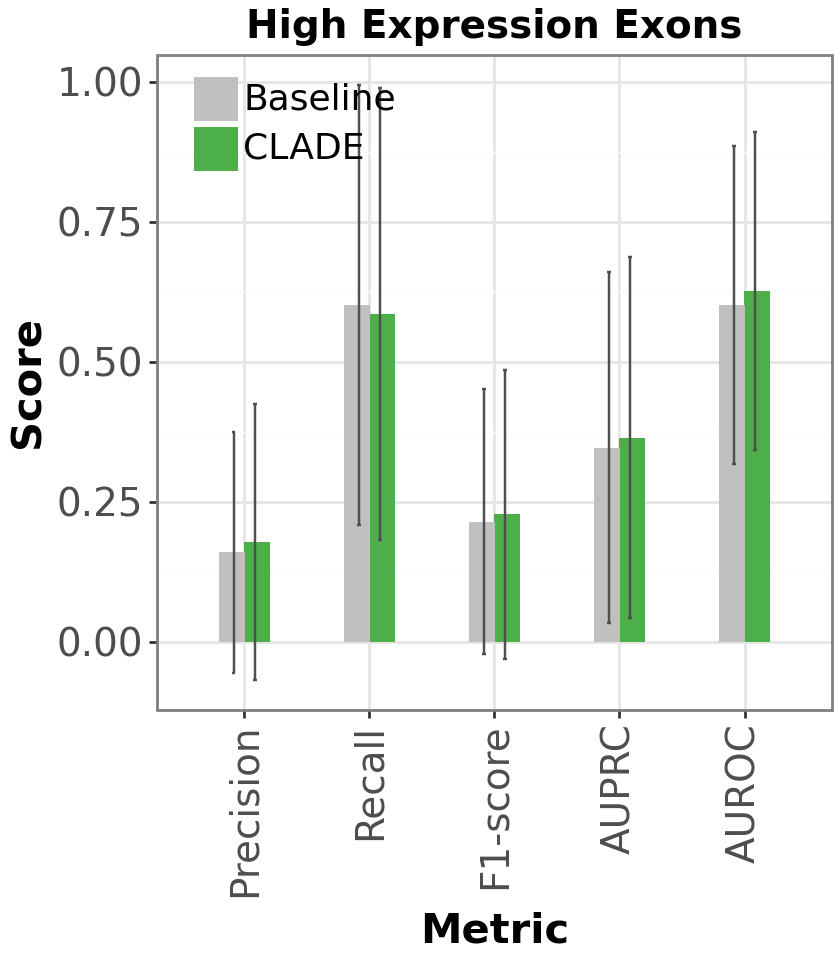

✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_Exon_High_SOTA_vs_CLADE_20251108_234021.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_Exon_High_SOTA_vs_CLADE_20251108_234021.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_Exon_High_SOTA_vs_CLADE_20251108_234021.pdf
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_Exon_High_SOTA_vs_CLADE_20251108_234021.eps


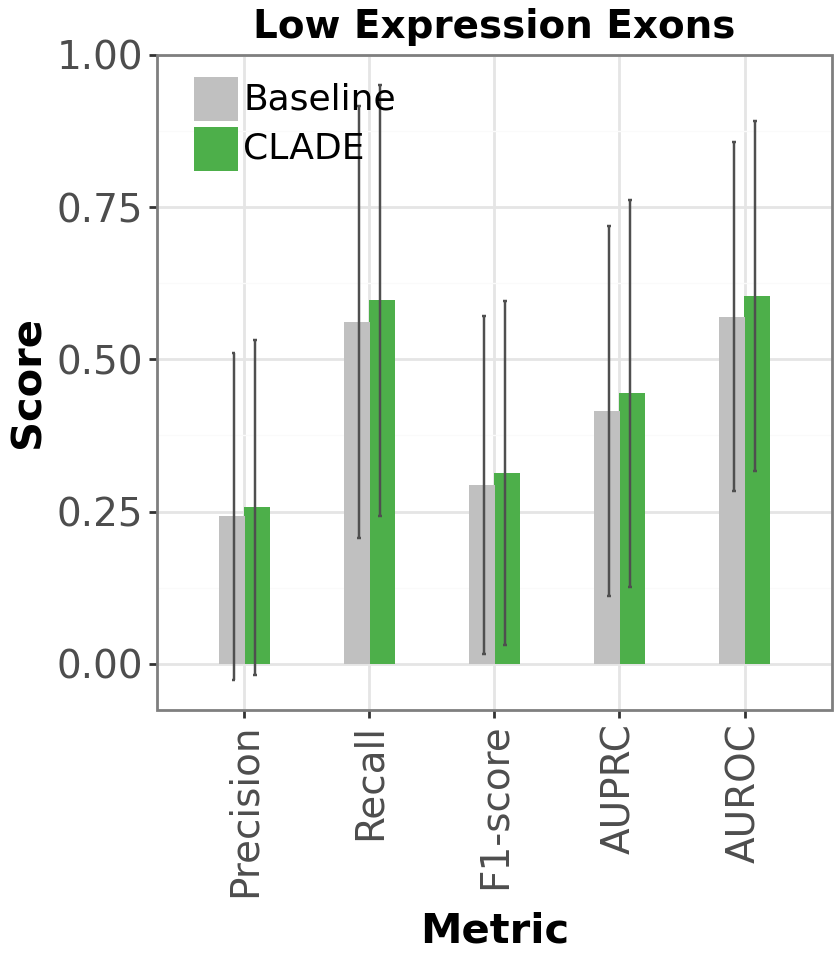

✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_Exon_Low_SOTA_vs_CLADE_20251108_234024.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_Exon_Low_SOTA_vs_CLADE_20251108_234024.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_Exon_Low_SOTA_vs_CLADE_20251108_234024.pdf
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_Exon_Low_SOTA_vs_CLADE_20251108_234024.eps


In [4]:
# %% [markdown]
# ## 4. Plot and Save


# %%
fig_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"


plot_expression_summary(summary_high, "High", fig_dir)
plot_expression_summary(summary_low, "Low", fig_dir)